In [ ]:
!unzip /content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/train/uncropped/train_set.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_set/2821.jpeg     
  inflating: train_set/30540.jpeg    
  inflating: train_set/3733.jpeg     
  inflating: train_set/35742.jpeg    
  inflating: train_set/6531.jpeg     
  inflating: train_set/32087.jpeg    
  inflating: train_set/29761.jpeg    
  inflating: train_set/34850.jpeg    
  inflating: train_set/26494.jpeg    
  inflating: train_set/21351.jpeg    
  inflating: train_set/16022.jpeg    
  inflating: train_set/12962.jpeg    
  inflating: train_set/24503.jpeg    
  inflating: train_set/691.jpeg      
  inflating: train_set/16188.jpeg    
  inflating: train_set/13670.jpeg    
  inflating: train_set/30110.jpeg    
  inflating: train_set/3363.jpeg     
  inflating: train_set/18895.jpeg    
  inflating: train_set/29331.jpeg    
  inflating: train_set/35312.jpeg    
  inflating: train_set/6161.jpeg     
  inflating: train_set/3699.jpeg     
  inflating: train_set/19787.jpeg    
  inflating: train_set/9294.jpeg     

In [ ]:
!python3 /content/drive/MyDrive/Owen/save_prediction_maps.py "/content/drive/MyDrive/Owen/resnet2_output/epoch47" "/content/train_set/train.csv" "/content/drive/MyDrive/Owen/segmented_images_multiplied/" "/content/drive/MyDrive/Owen/segmented_prediction_maps/"

  0% 0/32710 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 32710/32710 [7:01:12<00:00,  1.29it/s]


In [1]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from imutils import paths
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCELoss, Sequential, Conv2d, AvgPool2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Sigmoid
from torch.optim import Adam, SGD

import os
import joblib
import torch
import random
import albumentations
import matplotlib.pyplot as plt
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from PIL import Image
from tqdm import tqdm
from torchvision import models as models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [ ]:
labelled_data = pd.read_csv("/content/train_set/train.csv")

In [ ]:
labelled_data = labelled_data.drop("Unnamed: 0", axis="columns")
labelled_data = labelled_data.rename(columns={'Unnamed: 0.1':'image_name'})

In [ ]:
labelled_data['image_path'] = "/content/train_set/" + labelled_data['image_name'].astype(str) + ".jpeg"

In [ ]:
labelled_data['tensor_path'] = "/content/drive/MyDrive/Owen/prediction_maps/" + labelled_data['image_name'].astype(str) + ".pt"

In [ ]:
gss = GroupShuffleSplit(n_splits=2, train_size=0.8/0.9, random_state=42)
gss.get_n_splits()
groups = np.array(labelled_data["road_id"])

In [ ]:
train,test = next(gss.split(X = labelled_data, groups = groups))

In [ ]:
xtrain = labelled_data.iloc[train].tensor_path.values
xtest = labelled_data.iloc[test].tensor_path.values
ytrain = labelled_data.iloc[train].cracking_binary.values
ytest = labelled_data.iloc[test].cracking_binary.values

In [ ]:
np.mean(labelled_data.iloc[test].groupby(by=labelled_data["road_id"])["cracking_binary"].mean())

0.28333547640478335

In [ ]:
print(np.mean(ytest))

In [ ]:
# image dataset module
class prediction_maps(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels

    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        tensor = torch.load(self.X[i])
        tensor = F.interpolate(tensor,[224,224]).squeeze(dim=0)
        label = self.y[i]
        return tensor, torch.tensor(label, dtype=torch.long)

In [ ]:
train_data = prediction_maps(xtrain, ytrain, tfms=1)
test_data = prediction_maps(xtest, ytest, tfms=0)
 
# dataloaders
trainloader = DataLoader(train_data, batch_size=100, shuffle=True)
testloader = DataLoader(test_data, batch_size=100, shuffle=False)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f462d3e4a50>,
 <matplotlib.image.AxesImage at 0x7f46215d0ad0>)

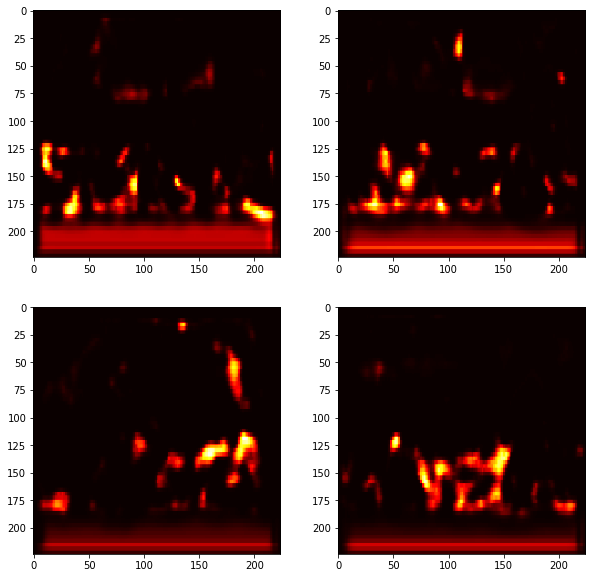

In [ ]:
# visualizing images
i = 10000
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(1/(1+np.exp(-train_data[i][0].squeeze().cpu())), cmap='hot')
plt.subplot(222), plt.imshow(1/(1+np.exp(-train_data[i+25][0].squeeze().cpu())), cmap='hot')
plt.subplot(223), plt.imshow(1/(1+np.exp(-train_data[i+50][0].squeeze().cpu())), cmap='hot')
plt.subplot(224), plt.imshow(1/(1+np.exp(-train_data[i+75][0].squeeze().cpu())), cmap='hot')

In [ ]:
class final_layers(nn.Module):
    def __init__(self):
        super(final_layers, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x.squeeze()

In [ ]:
# defining the model
model = models.resnet34(pretrained=False)
# defining the optimizer
model.fc = final_layers()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
optimizer = Adam(model.parameters(), lr=0.00003)
# defining the loss function
criterion = BCELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
''' SEED Everything '''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 
SEED=42
seed_everything(SEED=SEED)
''' SEED Everything '''
# set computation device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

Computation device: cuda:0


In [ ]:
#validation function
def validate(model, test_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader), total=int(len(test_data)/test_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs.float(), target.float())
            val_running_loss += loss.item()
            preds = torch.round(outputs.data)
            val_running_correct += (preds == target).sum().item()
            true_positives += ((preds == 1)&(target == 1)).sum().item()
            true_negatives += ((preds == 0)&(target == 0)).sum().item()
            false_positives += ((preds == 1)&(target == 0)).sum().item()
            false_negatives += ((preds == 0)&(target == 1)).sum().item()
        
        try:
          precision = true_positives/(true_positives+false_positives)
          recall = true_positives/(true_positives+false_negatives)
          f1 = 2 * (precision*recall)/(precision+recall)
        except:
          f1 = 0
          precision = 0
          recall = 0
        val_loss = val_running_loss/int(len(test_data)/test_dataloader.batch_size)
        val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
        
        return val_loss, val_accuracy, f1

In [ ]:
# training function
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs.float(), target.float())
        train_running_loss += loss.item()
        preds = torch.round(outputs.data)
        train_running_correct += (preds == target).sum().item()
        true_positives += ((preds == 1)&(target == 1)).sum().item()
        true_negatives += ((preds == 0)&(target == 0)).sum().item()
        false_positives += ((preds == 1)&(target == 0)).sum().item()
        false_negatives += ((preds == 0)&(target == 1)).sum().item()
        loss.backward()
        optimizer.step()
    try:
      precision = true_positives/(true_positives+false_positives)
      recall = true_positives/(true_positives+false_negatives)
      f1 = 2 * (precision*recall)/(precision+recall)
    except:
      precision = 0
      recall = 0
      f1 = 0
    train_loss = train_running_loss/int(len(train_data)/train_dataloader.batch_size)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
    
    return train_loss, train_accuracy, f1

In [ ]:
train_loss , train_accuracy , train_f1 = [], [], []
val_loss , val_accuracy, val_f1 = [], [], []
start = time.time()
epochs = 75
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy, train_epoch_f1 = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy, val_epoch_f1 = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_f1.append(train_epoch_f1)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_f1.append(val_epoch_f1)
    path = "/content/drive/MyDrive/Owen/output/epoch" + str(epoch)
    torch.save(model.state_dict(), path)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")

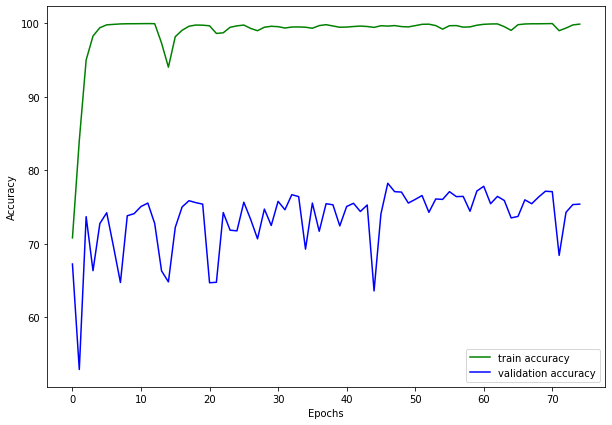

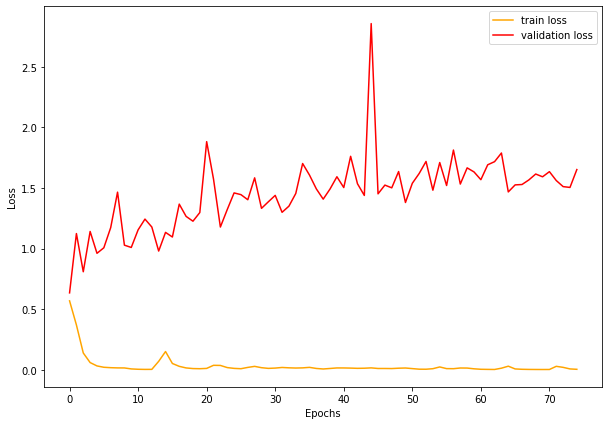

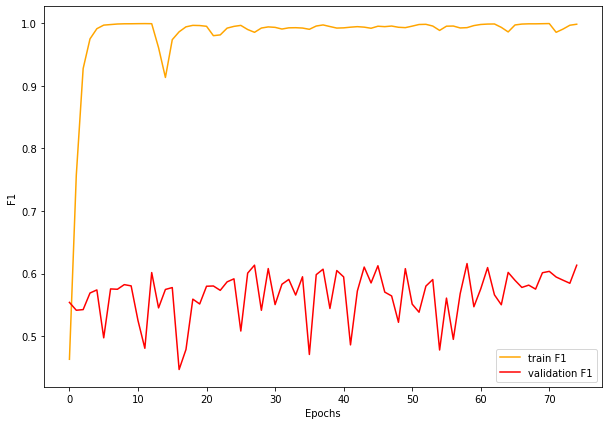

In [ ]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/accuracy (2).png')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/loss (2).png')
plt.show()
# F1 plots
plt.figure(figsize=(10, 7))
plt.plot(train_f1, color='orange', label='train F1')
plt.plot(val_f1, color='red', label='validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/F1 (2).png')
plt.show()

In [ ]:
for i,val in enumerate(val_f1):
  if val == max(val_f1):
    print(i)

58


In [ ]:
results = pd.DataFrame({'Train Accuracy':train_accuracy,
                        'Validation Accuracy':val_accuracy,
                        'Train Loss':train_loss, 
                        'Validation Loss':val_loss,
                        'Train F1':train_f1,
                        'Validation F1':val_f1}, 
                         columns=['Train Accuracy','Validation Accuracy', 'Train Loss', 'Validation Loss',
                                  'Train F1', "Validation F1"])

In [ ]:
results.to_csv("/content/drive/MyDrive/Owen/final_results/second_cnn_no_mask_full_labels.csv")

In [ ]:
labelled_data['inspection_id'] = labelled_data['road_id'] + labelled_data['inspection_date']

In [ ]:
fulltestloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
inspection_ids = labelled_data.iloc[test].inspection_id.unique()
inspections_x = labelled_data.iloc[test].inspection_id.values
inspections_y = labelled_data.loc[test,'cracking_binary'].groupby(by=inspections_x).max()

In [ ]:
from sklearn.metrics import f1_score
inspection_ids = labelled_data.iloc[test].inspection_id.unique()
inspections_x = labelled_data.iloc[test].inspection_id.values
inspections_y = labelled_data.loc[test,'cracking_binary'].groupby(by=inspections_x).max()
f1_scores_max = []
f1_scores_mean = []
f1_scores_majority = []
f1_scores_top2 = []
f1_scores_product = []
road_level = pd.DataFrame()
for a in range(75):
  print("Epoch: ", a)
  path = "/content/drive/MyDrive/Owen/output/epoch" + str(a)
  model.load_state_dict(torch.load(path))
  model.eval
  road_truths = []
  max_preds = []
  mean_preds = []
  majority_preds = []
  toptwo_preds = []
  product_preds = []
  for i,inspection in tqdm(enumerate(inspection_ids), total=len(inspection_ids)):
      images_x = xtest[inspections_x==inspection]
      images_y = ytest[inspections_x==inspection]
      test_data = prediction_maps(images_x, images_y, tfms=0)
      with torch.no_grad():
        test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
        for i, data in enumerate(test_dataloader):
          data = data[0].to(device)
          outputs = model(data)
          road_truth = np.amax(images_y)
          max_pred = torch.round(torch.max(outputs.data)).item()
          mean_pred = torch.round(torch.mean(outputs.data)).item()
          majority_pred = torch.round(torch.mean(torch.round(outputs.data))).item()
          product_pred = torch.round(1-torch.prod(1-outputs.data)).item()
          if len(outputs.size())==0:
            top2_pred = torch.round(torch.max(outputs)).item()
          else:
            top2 = torch.topk(outputs, 2).values
            top2_pred = torch.round(torch.mean(top2)).item()
          road_truths.append(road_truth)
          max_preds.append(max_pred)
          mean_preds.append(mean_pred)
          majority_preds.append(majority_pred)
          toptwo_preds.append(top2_pred)
          product_preds.append(product_pred)
          road_level = road_level.append(pd.DataFrame([[a,inspection,
                                                        road_truth,torch.max(outputs.data).item(),
                                                        torch.mean(outputs.data).item(),
                                                        torch.mean(torch.round(outputs.data)).item(),
                                                        (1-torch.prod(1-outputs.data)).item()]]))
  f1_max = f1_score(road_truths, max_preds)
  f1_mean = f1_score(road_truths, mean_preds)
  f1_majority = f1_score(road_truths, majority_preds)
  f1_top2 = f1_score(road_truths, toptwo_preds)
  f1_product = f1_score(road_truths, product_preds)
  print(f1_max, f1_mean, f1_majority, f1_top2, f1_product)
  f1_scores_max.append(f1_max)
  f1_scores_mean.append(f1_mean)
  f1_scores_majority.append(f1_majority)
  f1_scores_top2.append(f1_top2)
  f1_scores_product.append(f1_product)

AttributeError: ignored

In [ ]:
blind_test = pd.read_csv("/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/test.csv")

In [ ]:
blind_test = blind_test.drop("Unnamed: 0", axis="columns")
blind_test = blind_test.rename(columns={'Unnamed: 0.1':'image_name'})

In [ ]:
blind_test['image_path'] = "/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/" + blind_test['image_name'].astype("str") + ".jpeg"

In [ ]:
blind_test['tensor_path'] = "/content/drive/MyDrive/Owen/prediction_maps_blind_test/" + blind_test['image_name'].astype("str") + ".pt"

In [ ]:
blind_test['inspection_id'] = blind_test['road_id'] + blind_test['inspection_date']

In [ ]:
np.mean(blind_test.groupby(by=blind_test["inspection_id"])["cracking_binary"].mean())

0.3286384976525822

In [ ]:
inspection_ids = blind_test.inspection_id.unique()
x_blind = blind_test.tensor_path.values
y_blind = blind_test.cracking_binary.values
inspections_x = blind_test.inspection_id.values
inspections_y = blind_test['cracking_binary'].groupby(by=inspections_x).max()

In [ ]:
!python3 /content/drive/MyDrive/Owen/save_prediction_maps.py "/content/drive/MyDrive/Owen/resnet2_output/epoch47" "/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/test.csv" "/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/" "/content/drive/MyDrive/Owen/prediction_maps_blind_test/"

  0% 0/3736 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 3736/3736 [48:33<00:00,  1.28it/s]


In [ ]:
from sklearn.metrics import f1_score


model.load_state_dict(torch.load("/content/drive/MyDrive/Owen/final_2nd_cnn_epoch"))
model.eval
road_truths = []
max_preds = []
mean_preds = []
majority_preds = []
toptwo_preds = []
product_preds = []
max_scores = []
for i,inspection in tqdm(enumerate(inspection_ids), total=len(inspection_ids)):
    images_x = x_blind[inspections_x==inspection]
    images_y = y_blind[inspections_x==inspection]
    test_data = prediction_maps(images_x, images_y, tfms=0)
    with torch.no_grad():
      test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
      for i, data in enumerate(test_dataloader):
        data = data[0].to(device)
        outputs = model(data)
        road_truth = np.amax(images_y)
        max_score = torch.max(outputs.data).item()
        max_pred = torch.round(torch.max(outputs.data)).item()
        mean_pred = torch.round(torch.mean(outputs.data)).item()
        majority_pred = torch.round(torch.mean(torch.round(outputs.data))).item()
        product_pred = torch.round(1-torch.prod(1-outputs.data)).item()
        if len(outputs.size())==0:
          top2_pred = torch.round(torch.max(outputs)).item()
        else:
          top2 = torch.topk(outputs, 2).values
          top2_pred = torch.round(torch.mean(top2)).item()
        road_truths.append(road_truth)
        max_preds.append(max_pred)
        mean_preds.append(mean_pred)
        majority_preds.append(majority_pred)
        toptwo_preds.append(top2_pred)
        product_preds.append(product_pred)
        max_scores.append(max_score)
f1_max = f1_score(road_truths, max_preds)
f1_mean = f1_score(road_truths, mean_preds)
f1_majority = f1_score(road_truths, majority_preds)
f1_top2 = f1_score(road_truths, toptwo_preds)
f1_product = f1_score(road_truths, product_preds)
print(f1_max, f1_mean, f1_majority, f1_top2,f1_product)

100%|██████████| 213/213 [03:49<00:00,  1.08s/it]

0.4960629921259843 0.0 0.0 0.4892703862660944 0.4941176470588236


In [ ]:
from sklearn import metrics

print(metrics.accuracy_score(road_truths, max_preds))
print(metrics.recall_score(road_truths, max_preds))
print(metrics.precision_score(road_truths, max_preds))
print(metrics.f1_score(road_truths, max_preds))
print(metrics.confusion_matrix(road_truths, max_preds))

0.39906103286384975
0.9
0.3423913043478261
0.4960629921259843
[[ 22 121]
 [  7  63]]


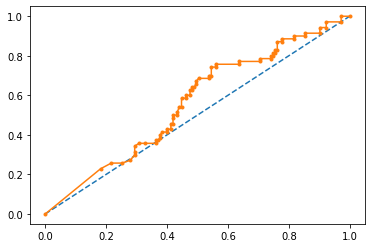

In [ ]:
from matplotlib import pyplot
from sklearn import metrics as metric
ns_probs = [0 for _ in range(len(road_truths))]
ns_fpr, ns_tpr, _ = metric.roc_curve(road_truths, ns_probs)
lr_fpr, lr_tpr, _ = metric.roc_curve(road_truths, max_scores)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

In [ ]:
ROC = pd.DataFrame({'FPR':lr_fpr,
                    'TPR':lr_tpr})

In [ ]:
ROC.to_csv("/content/drive/MyDrive/Owen/final_results/stacked_cnn_ROC.csv")

# Stacked CNN after Segmentation


In [ ]:
!python3 /content/drive/MyDrive/Owen/save_prediction_maps.py "/content/drive/MyDrive/Owen/resnet2_output_segmented/epoch38" "/content/train_set/train.csv" "/content/drive/MyDrive/Owen/segmented_images_multiplied/" "/content/drive/MyDrive/Owen/segmented_prediction_maps/"

  0% 0/32710 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
 89% 29102/32710 [2:59:52<1:03:09,  1.05s/it]

In [ ]:
labelled_data = pd.read_csv("/content/train_set/train.csv")

In [ ]:
labelled_data = labelled_data.drop("Unnamed: 0", axis="columns")
labelled_data = labelled_data.rename(columns={'Unnamed: 0.1':'image_name'})

In [ ]:
labelled_data['image_path'] = "/content/train_set/" + labelled_data['image_name'].astype(str) + ".jpeg"

In [ ]:
labelled_data['segmented_tensor_path'] = "/content/drive/MyDrive/Owen/segmented_prediction_maps/" + labelled_data['image_name'].astype(str) + ".pt"

In [ ]:
gss = GroupShuffleSplit(n_splits=2, train_size=0.8/0.9, random_state=42)
gss.get_n_splits()
groups = np.array(labelled_data["road_id"])

In [ ]:
train,test = next(gss.split(X = labelled_data, groups = groups))

In [ ]:
xtrain = labelled_data.iloc[train].segmented_tensor_path.values
xtest = labelled_data.iloc[test].segmented_tensor_path.values
ytrain = labelled_data.iloc[train].cracking_binary.values
ytest = labelled_data.iloc[test].cracking_binary.values

In [ ]:
# image dataset module
class prediction_maps(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels

    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        tensor = torch.load(self.X[i])
        tensor = F.interpolate(tensor,[224,224]).squeeze(dim=0)
        label = self.y[i]
        return tensor, torch.tensor(label, dtype=torch.long)

In [ ]:
train_data = prediction_maps(xtrain, ytrain, tfms=1)
test_data = prediction_maps(xtest, ytest, tfms=0)
 
# dataloaders
trainloader = DataLoader(train_data, batch_size=100, shuffle=True)
testloader = DataLoader(test_data, batch_size=100, shuffle=False)

KeyboardInterrupt: ignored

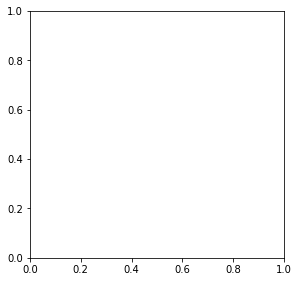

In [ ]:
# visualizing images
i = 10000
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(1/(1+np.exp(-train_data[i][0].squeeze().cpu())), cmap='hot')
plt.subplot(222), plt.imshow(1/(1+np.exp(-train_data[i+25][0].squeeze().cpu())), cmap='hot')
plt.subplot(223), plt.imshow(1/(1+np.exp(-train_data[i+50][0].squeeze().cpu())), cmap='hot')
plt.subplot(224), plt.imshow(1/(1+np.exp(-train_data[i+75][0].squeeze().cpu())), cmap='hot')

In [ ]:
class final_layers(nn.Module):
    def __init__(self):
        super(final_layers, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x.squeeze()

In [ ]:
# defining the model
model = models.resnet34(pretrained=False)
# defining the optimizer
model.fc = final_layers()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
optimizer = Adam(model.parameters(), lr=0.00003)
# defining the loss function
criterion = BCELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
''' SEED Everything '''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 
SEED=42
seed_everything(SEED=SEED)
''' SEED Everything '''
# set computation device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

Computation device: cuda:0


In [ ]:
#validation function
def validate(model, test_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader), total=int(len(test_data)/test_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs.float(), target.float())
            val_running_loss += loss.item()
            preds = torch.round(outputs.data)
            val_running_correct += (preds == target).sum().item()
            true_positives += ((preds == 1)&(target == 1)).sum().item()
            true_negatives += ((preds == 0)&(target == 0)).sum().item()
            false_positives += ((preds == 1)&(target == 0)).sum().item()
            false_negatives += ((preds == 0)&(target == 1)).sum().item()
        
        try:
          precision = true_positives/(true_positives+false_positives)
          recall = true_positives/(true_positives+false_negatives)
          f1 = 2 * (precision*recall)/(precision+recall)
        except:
          f1 = 0
          precision = 0
          recall = 0
        val_loss = val_running_loss/int(len(test_data)/test_dataloader.batch_size)
        val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
        
        return val_loss, val_accuracy, f1

In [ ]:
# training function
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs.float(), target.float())
        train_running_loss += loss.item()
        preds = torch.round(outputs.data)
        train_running_correct += (preds == target).sum().item()
        true_positives += ((preds == 1)&(target == 1)).sum().item()
        true_negatives += ((preds == 0)&(target == 0)).sum().item()
        false_positives += ((preds == 1)&(target == 0)).sum().item()
        false_negatives += ((preds == 0)&(target == 1)).sum().item()
        loss.backward()
        optimizer.step()
    try:
      precision = true_positives/(true_positives+false_positives)
      recall = true_positives/(true_positives+false_negatives)
      f1 = 2 * (precision*recall)/(precision+recall)
    except:
      precision = 0
      recall = 0
      f1 = 0
    train_loss = train_running_loss/int(len(train_data)/train_dataloader.batch_size)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
    
    return train_loss, train_accuracy, f1

In [ ]:
train_loss , train_accuracy , train_f1 = [], [], []
val_loss , val_accuracy, val_f1 = [], [], []
start = time.time()
epochs = 75
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy, train_epoch_f1 = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy, val_epoch_f1 = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_f1.append(train_epoch_f1)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_f1.append(val_epoch_f1)
    path = "/content/drive/MyDrive/Owen/maskplusstackedoutput/epoch" + str(epoch)
    torch.save(model.state_dict(), path)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")

  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 1 of 75
Training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
293it [2:07:53, 26.19s/it]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.5926, Train Acc: 70.12
Recall: 0.3093, Precision: 0.65, F1: 0.42
Validating


35it [14:15, 24.45s/it]


Val Loss: 0.7861, Val Acc: 53.09
Recall: 0.6996, Precision: 0.36, F1: 0.48


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 2 of 75
Training


293it [01:53,  2.58it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.5033, Train Acc: 76.31
Recall: 0.4828, Precision: 0.75, F1: 0.59
Validating


35it [00:07,  4.60it/s]                        


Val Loss: 0.7821, Val Acc: 72.70
Recall: 0.1255, Precision: 0.91, F1: 0.22


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 3 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.3902, Train Acc: 82.44
Recall: 0.6128, Precision: 0.84, F1: 0.71
Validating


35it [00:07,  4.71it/s]                        


Val Loss: 0.7470, Val Acc: 67.75
Recall: 0.4487, Precision: 0.47, F1: 0.46


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 4 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.2789, Train Acc: 87.61
Recall: 0.7084, Precision: 0.92, F1: 0.80
Validating


35it [00:07,  4.75it/s]                        


Val Loss: 0.8734, Val Acc: 69.01
Recall: 0.4306, Precision: 0.50, F1: 0.46


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 5 of 75
Training


293it [01:52,  2.59it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.2180, Train Acc: 90.12
Recall: 0.7510, Precision: 0.96, F1: 0.84
Validating


35it [00:07,  4.70it/s]                        


Val Loss: 1.1451, Val Acc: 72.23
Recall: 0.2586, Precision: 0.62, F1: 0.36


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 6 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1902, Train Acc: 91.19
Recall: 0.7683, Precision: 0.97, F1: 0.86
Validating


35it [00:07,  4.64it/s]                        


Val Loss: 1.2413, Val Acc: 71.85
Recall: 0.3165, Precision: 0.58, F1: 0.41


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 7 of 75
Training


293it [01:52,  2.60it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1770, Train Acc: 91.80
Recall: 0.7764, Precision: 0.98, F1: 0.87
Validating


35it [00:07,  4.75it/s]                        


Val Loss: 1.3211, Val Acc: 67.49
Recall: 0.5285, Precision: 0.47, F1: 0.50


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 8 of 75
Training


293it [01:52,  2.60it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1784, Train Acc: 91.67
Recall: 0.7763, Precision: 0.98, F1: 0.87
Validating


35it [00:07,  4.83it/s]                        


Val Loss: 1.2945, Val Acc: 73.28
Recall: 0.3099, Precision: 0.64, F1: 0.42


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 9 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1715, Train Acc: 91.88
Recall: 0.7770, Precision: 0.99, F1: 0.87
Validating


35it [00:07,  4.69it/s]                        


Val Loss: 1.5611, Val Acc: 72.55
Recall: 0.2338, Precision: 0.65, F1: 0.34


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 10 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1726, Train Acc: 91.84
Recall: 0.7778, Precision: 0.98, F1: 0.87
Validating


35it [00:07,  4.72it/s]                        


Val Loss: 1.2459, Val Acc: 70.79
Recall: 0.4316, Precision: 0.53, F1: 0.48


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 11 of 75
Training


293it [01:51,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1683, Train Acc: 91.96
Recall: 0.7799, Precision: 0.99, F1: 0.87
Validating


35it [00:07,  4.72it/s]                        


Val Loss: 1.2699, Val Acc: 70.76
Recall: 0.3736, Precision: 0.54, F1: 0.44


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 12 of 75
Training


293it [01:53,  2.59it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1648, Train Acc: 92.08
Recall: 0.7808, Precision: 0.99, F1: 0.87
Validating


35it [00:07,  4.52it/s]                        


Val Loss: 1.3425, Val Acc: 68.28
Recall: 0.4658, Precision: 0.48, F1: 0.47


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 13 of 75
Training


293it [01:51,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1674, Train Acc: 92.00
Recall: 0.7800, Precision: 0.99, F1: 0.87
Validating


35it [00:07,  4.85it/s]                        


Val Loss: 1.3781, Val Acc: 70.38
Recall: 0.3812, Precision: 0.53, F1: 0.44


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 14 of 75
Training


293it [01:51,  2.63it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1660, Train Acc: 91.95
Recall: 0.7792, Precision: 0.99, F1: 0.87
Validating


35it [00:07,  4.79it/s]                        


Val Loss: 1.4360, Val Acc: 72.11
Recall: 0.3251, Precision: 0.58, F1: 0.42


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 15 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1688, Train Acc: 91.91
Recall: 0.7791, Precision: 0.98, F1: 0.87
Validating


35it [00:07,  4.79it/s]                        


Val Loss: 1.4171, Val Acc: 72.72
Recall: 0.3308, Precision: 0.60, F1: 0.43


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 16 of 75
Training


293it [01:51,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1620, Train Acc: 92.14
Recall: 0.7821, Precision: 0.99, F1: 0.87
Validating


35it [00:07,  4.83it/s]                        


Val Loss: 1.5528, Val Acc: 71.99
Recall: 0.2842, Precision: 0.59, F1: 0.38


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 17 of 75
Training


293it [01:51,  2.63it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1636, Train Acc: 92.07
Recall: 0.7812, Precision: 0.99, F1: 0.87
Validating


35it [00:07,  4.77it/s]                        


Val Loss: 1.5256, Val Acc: 71.17
Recall: 0.3356, Precision: 0.55, F1: 0.42


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 18 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1618, Train Acc: 92.17
Recall: 0.7827, Precision: 0.99, F1: 0.87
Validating


35it [00:07,  4.77it/s]                        


Val Loss: 1.4978, Val Acc: 72.81
Recall: 0.2956, Precision: 0.62, F1: 0.40


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 19 of 75
Training


293it [01:51,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1594, Train Acc: 92.21
Recall: 0.7825, Precision: 0.99, F1: 0.87
Validating


35it [00:07,  4.73it/s]                        


Val Loss: 1.5752, Val Acc: 69.07
Recall: 0.4743, Precision: 0.50, F1: 0.49


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 20 of 75
Training


293it [01:52,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1587, Train Acc: 92.18
Recall: 0.7832, Precision: 0.99, F1: 0.87
Validating


35it [00:07,  4.78it/s]                        


Val Loss: 1.5782, Val Acc: 71.35
Recall: 0.4173, Precision: 0.55, F1: 0.47


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 21 of 75
Training


293it [01:51,  2.63it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1659, Train Acc: 91.93
Recall: 0.7779, Precision: 0.99, F1: 0.87
Validating


35it [00:07,  4.83it/s]                        


Val Loss: 1.4818, Val Acc: 71.00
Recall: 0.4116, Precision: 0.54, F1: 0.47


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 22 of 75
Training


293it [01:52,  2.60it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1576, Train Acc: 92.30
Recall: 0.7846, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.86it/s]                        


Val Loss: 1.5242, Val Acc: 73.11
Recall: 0.3051, Precision: 0.63, F1: 0.41


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 23 of 75
Training


293it [01:51,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1557, Train Acc: 92.35
Recall: 0.7852, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.78it/s]                        


Val Loss: 1.8458, Val Acc: 69.45
Recall: 0.4363, Precision: 0.50, F1: 0.47


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 24 of 75
Training


293it [01:51,  2.63it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1599, Train Acc: 92.18
Recall: 0.7832, Precision: 0.99, F1: 0.87
Validating


35it [00:07,  4.86it/s]                        


Val Loss: 2.1029, Val Acc: 73.66
Recall: 0.2139, Precision: 0.76, F1: 0.33


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 25 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1633, Train Acc: 92.05
Recall: 0.7801, Precision: 0.99, F1: 0.87
Validating


35it [00:07,  4.70it/s]                        


Val Loss: 1.7121, Val Acc: 72.93
Recall: 0.2966, Precision: 0.63, F1: 0.40


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 26 of 75
Training


293it [01:51,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1559, Train Acc: 92.32
Recall: 0.7848, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.83it/s]                        


Val Loss: 1.9415, Val Acc: 72.23
Recall: 0.2253, Precision: 0.64, F1: 0.33


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 27 of 75
Training


293it [01:51,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1558, Train Acc: 92.35
Recall: 0.7842, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.72it/s]                        


Val Loss: 1.6533, Val Acc: 70.82
Recall: 0.3954, Precision: 0.54, F1: 0.45


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 28 of 75
Training


293it [01:53,  2.59it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1560, Train Acc: 92.33
Recall: 0.7856, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.69it/s]                        


Val Loss: 1.9595, Val Acc: 73.92
Recall: 0.2728, Precision: 0.69, F1: 0.39


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 29 of 75
Training


293it [01:51,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1601, Train Acc: 92.14
Recall: 0.7823, Precision: 0.99, F1: 0.87
Validating


35it [00:07,  4.83it/s]                        


Val Loss: 1.6555, Val Acc: 70.47
Recall: 0.4544, Precision: 0.52, F1: 0.49


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 30 of 75
Training


293it [01:51,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1623, Train Acc: 92.06
Recall: 0.7800, Precision: 0.99, F1: 0.87
Validating


35it [00:07,  4.86it/s]                        


Val Loss: 1.6226, Val Acc: 68.45
Recall: 0.5086, Precision: 0.49, F1: 0.50


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 31 of 75
Training


293it [01:51,  2.63it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1566, Train Acc: 92.31
Recall: 0.7856, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.77it/s]                        


Val Loss: 1.6913, Val Acc: 72.87
Recall: 0.2738, Precision: 0.64, F1: 0.38


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 32 of 75
Training


293it [01:51,  2.64it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1560, Train Acc: 92.32
Recall: 0.7842, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.88it/s]                        


Val Loss: 1.5934, Val Acc: 72.67
Recall: 0.3603, Precision: 0.59, F1: 0.45


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 33 of 75
Training


293it [01:51,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1505, Train Acc: 92.54
Recall: 0.7877, Precision: 1.00, F1: 0.88
Validating


35it [00:07,  4.79it/s]                        


Val Loss: 2.0402, Val Acc: 73.66
Recall: 0.2510, Precision: 0.70, F1: 0.37


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 34 of 75
Training


293it [01:51,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1558, Train Acc: 92.30
Recall: 0.7852, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.82it/s]                        


Val Loss: 1.6408, Val Acc: 71.58
Recall: 0.3375, Precision: 0.56, F1: 0.42


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 35 of 75
Training


293it [01:51,  2.64it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1592, Train Acc: 92.22
Recall: 0.7835, Precision: 0.99, F1: 0.87
Validating


35it [00:07,  4.78it/s]                        


Val Loss: 1.7813, Val Acc: 72.29
Recall: 0.3793, Precision: 0.58, F1: 0.46


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 36 of 75
Training


293it [01:50,  2.64it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1578, Train Acc: 92.26
Recall: 0.7839, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.86it/s]                        


Val Loss: 1.8167, Val Acc: 70.15
Recall: 0.4477, Precision: 0.52, F1: 0.48


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 37 of 75
Training


293it [01:51,  2.64it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1567, Train Acc: 92.23
Recall: 0.7840, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.82it/s]                        


Val Loss: 1.6822, Val Acc: 72.49
Recall: 0.3907, Precision: 0.58, F1: 0.47


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 38 of 75
Training


293it [01:51,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1534, Train Acc: 92.38
Recall: 0.7859, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.78it/s]                        


Val Loss: 1.8986, Val Acc: 72.02
Recall: 0.3660, Precision: 0.57, F1: 0.45


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 39 of 75
Training


293it [01:51,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1553, Train Acc: 92.37
Recall: 0.7852, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.68it/s]                        


Val Loss: 1.9467, Val Acc: 72.43
Recall: 0.2643, Precision: 0.62, F1: 0.37


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 40 of 75
Training


293it [01:51,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1554, Train Acc: 92.33
Recall: 0.7847, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.85it/s]                        


Val Loss: 1.7302, Val Acc: 71.47
Recall: 0.4344, Precision: 0.55, F1: 0.48


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 41 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1542, Train Acc: 92.38
Recall: 0.7855, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.76it/s]                        


Val Loss: 1.7362, Val Acc: 71.17
Recall: 0.4753, Precision: 0.54, F1: 0.50


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 42 of 75
Training


293it [01:51,  2.64it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1605, Train Acc: 92.18
Recall: 0.7853, Precision: 0.99, F1: 0.87
Validating


35it [00:07,  4.76it/s]                        


Val Loss: 1.4813, Val Acc: 72.61
Recall: 0.2994, Precision: 0.61, F1: 0.40


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 43 of 75
Training


293it [01:50,  2.64it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1529, Train Acc: 92.47
Recall: 0.7876, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.82it/s]                        


Val Loss: 1.5099, Val Acc: 73.22
Recall: 0.3812, Precision: 0.60, F1: 0.47


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 44 of 75
Training


293it [01:50,  2.65it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1496, Train Acc: 92.57
Recall: 0.7888, Precision: 1.00, F1: 0.88
Validating


35it [00:07,  4.87it/s]                        


Val Loss: 1.5940, Val Acc: 72.72
Recall: 0.3869, Precision: 0.59, F1: 0.47


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 45 of 75
Training


293it [01:52,  2.60it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1523, Train Acc: 92.45
Recall: 0.7870, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.69it/s]                        


Val Loss: 1.6869, Val Acc: 68.60
Recall: 0.5200, Precision: 0.49, F1: 0.50


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 46 of 75
Training


293it [01:52,  2.60it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1581, Train Acc: 92.24
Recall: 0.7835, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.76it/s]                        


Val Loss: 1.6884, Val Acc: 71.29
Recall: 0.4392, Precision: 0.54, F1: 0.49


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 47 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1564, Train Acc: 92.29
Recall: 0.7847, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.80it/s]                        


Val Loss: 1.9659, Val Acc: 73.13
Recall: 0.2405, Precision: 0.68, F1: 0.36


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 48 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1550, Train Acc: 92.36
Recall: 0.7850, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.68it/s]                        


Val Loss: 1.7231, Val Acc: 72.31
Recall: 0.3546, Precision: 0.58, F1: 0.44


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 49 of 75
Training


293it [01:51,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1520, Train Acc: 92.44
Recall: 0.7866, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.69it/s]                        


Val Loss: 1.9819, Val Acc: 72.17
Recall: 0.2671, Precision: 0.61, F1: 0.37


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 50 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1529, Train Acc: 92.41
Recall: 0.7858, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.70it/s]                        


Val Loss: 1.7374, Val Acc: 73.25
Recall: 0.3337, Precision: 0.62, F1: 0.43


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 51 of 75
Training


293it [01:51,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1514, Train Acc: 92.52
Recall: 0.7875, Precision: 1.00, F1: 0.88
Validating


35it [00:07,  4.70it/s]                        


Val Loss: 2.0293, Val Acc: 72.90
Recall: 0.2966, Precision: 0.63, F1: 0.40


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 52 of 75
Training


293it [01:51,  2.63it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1498, Train Acc: 92.56
Recall: 0.7884, Precision: 1.00, F1: 0.88
Validating


35it [00:07,  4.75it/s]                        


Val Loss: 1.9388, Val Acc: 71.76
Recall: 0.4249, Precision: 0.55, F1: 0.48


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 53 of 75
Training


293it [01:52,  2.60it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1518, Train Acc: 92.46
Recall: 0.7867, Precision: 1.00, F1: 0.88
Validating


35it [00:07,  4.41it/s]                        


Val Loss: 1.8459, Val Acc: 71.20
Recall: 0.3584, Precision: 0.55, F1: 0.43


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 54 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1573, Train Acc: 92.29
Recall: 0.7847, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.66it/s]                        


Val Loss: 1.7925, Val Acc: 71.85
Recall: 0.3954, Precision: 0.56, F1: 0.46


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 55 of 75
Training


293it [01:52,  2.60it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1526, Train Acc: 92.49
Recall: 0.7880, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.77it/s]                        


Val Loss: 1.9170, Val Acc: 73.13
Recall: 0.2766, Precision: 0.65, F1: 0.39


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 56 of 75
Training


293it [01:53,  2.59it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1516, Train Acc: 92.45
Recall: 0.7864, Precision: 1.00, F1: 0.88
Validating


35it [00:07,  4.77it/s]                        


Val Loss: 1.8594, Val Acc: 73.22
Recall: 0.3698, Precision: 0.61, F1: 0.46


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 57 of 75
Training


293it [01:51,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1546, Train Acc: 92.37
Recall: 0.7856, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.65it/s]                        


Val Loss: 2.2880, Val Acc: 74.01
Recall: 0.2766, Precision: 0.70, F1: 0.40


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 58 of 75
Training


293it [01:51,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1529, Train Acc: 92.43
Recall: 0.7861, Precision: 1.00, F1: 0.88
Validating


35it [00:07,  4.73it/s]                        


Val Loss: 1.7913, Val Acc: 70.12
Recall: 0.4810, Precision: 0.52, F1: 0.50


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 59 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1523, Train Acc: 92.46
Recall: 0.7869, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.76it/s]                        


Val Loss: 1.8881, Val Acc: 71.85
Recall: 0.3945, Precision: 0.56, F1: 0.46


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 60 of 75
Training


293it [01:51,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1513, Train Acc: 92.53
Recall: 0.7880, Precision: 1.00, F1: 0.88
Validating


35it [00:07,  4.63it/s]                        


Val Loss: 1.8648, Val Acc: 72.52
Recall: 0.4021, Precision: 0.58, F1: 0.47


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 61 of 75
Training


293it [01:52,  2.60it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1499, Train Acc: 92.54
Recall: 0.7881, Precision: 1.00, F1: 0.88
Validating


35it [00:07,  4.64it/s]                        


Val Loss: 1.8911, Val Acc: 70.82
Recall: 0.4173, Precision: 0.53, F1: 0.47


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 62 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1541, Train Acc: 92.39
Recall: 0.7863, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.78it/s]                        


Val Loss: 2.2826, Val Acc: 69.62
Recall: 0.4753, Precision: 0.51, F1: 0.49


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 63 of 75
Training


293it [01:52,  2.60it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1522, Train Acc: 92.46
Recall: 0.7868, Precision: 1.00, F1: 0.88
Validating


35it [00:07,  4.72it/s]                        


Val Loss: 2.0083, Val Acc: 73.19
Recall: 0.3755, Precision: 0.60, F1: 0.46


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 64 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1492, Train Acc: 92.58
Recall: 0.7892, Precision: 1.00, F1: 0.88
Validating


35it [00:07,  4.72it/s]                        


Val Loss: 1.9157, Val Acc: 72.70
Recall: 0.3793, Precision: 0.59, F1: 0.46


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 65 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1532, Train Acc: 92.42
Recall: 0.7867, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.68it/s]                        


Val Loss: 1.8517, Val Acc: 72.90
Recall: 0.3650, Precision: 0.60, F1: 0.45


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 66 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1530, Train Acc: 92.44
Recall: 0.7872, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.70it/s]                        


Val Loss: 1.7478, Val Acc: 71.73
Recall: 0.3926, Precision: 0.56, F1: 0.46


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 67 of 75
Training


293it [01:51,  2.62it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1519, Train Acc: 92.47
Recall: 0.7871, Precision: 1.00, F1: 0.88
Validating


35it [00:07,  4.70it/s]                        


Val Loss: 2.0780, Val Acc: 73.81
Recall: 0.3821, Precision: 0.62, F1: 0.47


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 68 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1508, Train Acc: 92.50
Recall: 0.7880, Precision: 1.00, F1: 0.88
Validating


35it [00:07,  4.77it/s]                        


Val Loss: 1.9797, Val Acc: 72.78
Recall: 0.3916, Precision: 0.59, F1: 0.47


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 69 of 75
Training


293it [01:52,  2.60it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1514, Train Acc: 92.44
Recall: 0.7866, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.74it/s]                        


Val Loss: 1.8591, Val Acc: 73.31
Recall: 0.3394, Precision: 0.62, F1: 0.44


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 70 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1500, Train Acc: 92.53
Recall: 0.7876, Precision: 1.00, F1: 0.88
Validating


35it [00:07,  4.56it/s]                        


Val Loss: 1.8343, Val Acc: 73.81
Recall: 0.3565, Precision: 0.63, F1: 0.46


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 71 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1523, Train Acc: 92.42
Recall: 0.7861, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.75it/s]                        


Val Loss: 1.8905, Val Acc: 72.17
Recall: 0.3793, Precision: 0.57, F1: 0.46


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 72 of 75
Training


293it [01:52,  2.61it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1546, Train Acc: 92.36
Recall: 0.7857, Precision: 0.99, F1: 0.88
Validating


35it [00:07,  4.75it/s]                        


Val Loss: 1.6901, Val Acc: 74.45
Recall: 0.3878, Precision: 0.64, F1: 0.48


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 73 of 75
Training


293it [01:52,  2.60it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1512, Train Acc: 92.49
Recall: 0.7876, Precision: 1.00, F1: 0.88
Validating


35it [00:07,  4.68it/s]                        


Val Loss: 2.0823, Val Acc: 73.11
Recall: 0.3232, Precision: 0.62, F1: 0.43


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 74 of 75
Training


293it [01:53,  2.59it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1498, Train Acc: 92.55
Recall: 0.7880, Precision: 1.00, F1: 0.88
Validating


35it [00:07,  4.65it/s]                        


Val Loss: 2.4836, Val Acc: 72.70
Recall: 0.3004, Precision: 0.62, F1: 0.40


  0%|          | 0/292 [00:00<?, ?it/s]

Epoch 75 of 75
Training


293it [01:53,  2.59it/s]
  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1503, Train Acc: 92.53
Recall: 0.7881, Precision: 1.00, F1: 0.88
Validating


35it [00:07,  4.49it/s]                        


Val Loss: 2.0390, Val Acc: 72.37
Recall: 0.3916, Precision: 0.58, F1: 0.47
291.864 minutes


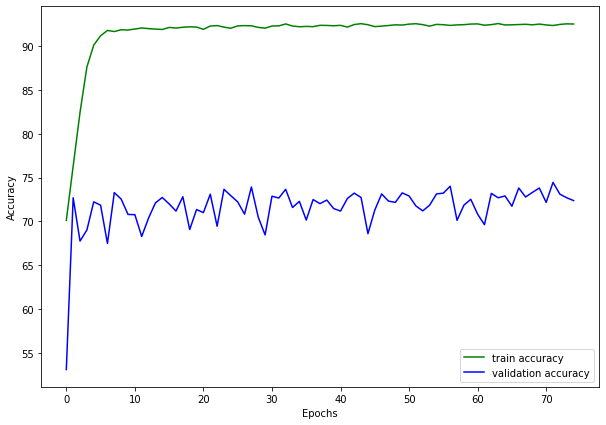

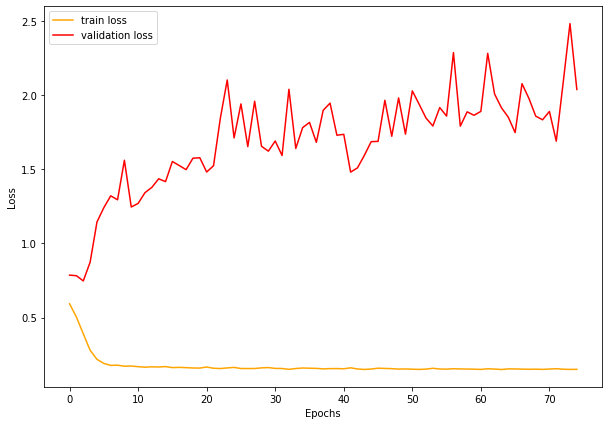

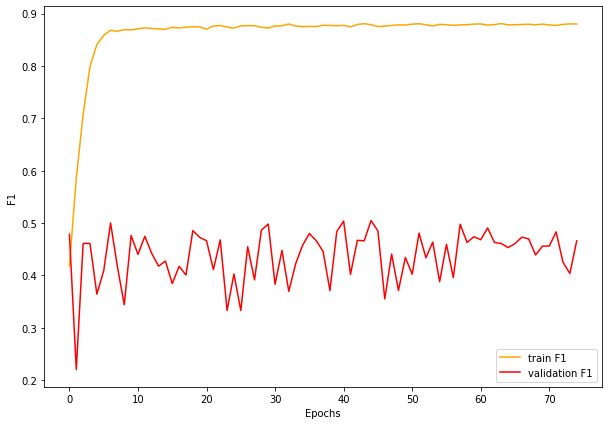

In [ ]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/accuracy (2).png')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/loss (2).png')
plt.show()
# F1 plots
plt.figure(figsize=(10, 7))
plt.plot(train_f1, color='orange', label='train F1')
plt.plot(val_f1, color='red', label='validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/F1 (2).png')
plt.show()

In [ ]:
for i,val in enumerate(val_f1):
  if val==max(val_f1):
    print(i)

44


In [ ]:
!python3 /content/drive/MyDrive/Owen/save_prediction_maps.py "/content/drive/MyDrive/Owen/resnet2_output_segmented/epoch38" "/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/test.csv" "/content/drive/MyDrive/Owen/segmented_images_blind_test/" "/content/drive/MyDrive/Owen/segmented_prediction_maps_blind_test/"

  0% 0/3736 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 3736/3736 [43:06<00:00,  1.44it/s]


In [ ]:
blind_test = pd.read_csv("/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/test.csv")

In [ ]:
blind_test = blind_test.drop("Unnamed: 0", axis="columns")
blind_test = blind_test.rename(columns={'Unnamed: 0.1':'image_name'})

In [ ]:
blind_test['image_path'] = "/content/drive/MyDrive/Owen/rddc2020/yolov5/datasets/amsterdam/test/" + blind_test['image_name'].astype("str") + ".jpeg"

In [ ]:
blind_test['tensor_path'] = "/content/drive/MyDrive/Owen/segmented_prediction_maps_blind_test/" + blind_test['image_name'].astype("str") + ".pt"

In [ ]:
blind_test['inspection_id'] = blind_test['road_id'] + blind_test['inspection_date']

In [ ]:
inspection_ids = blind_test.inspection_id.unique()
x_blind = blind_test.tensor_path.values
y_blind = blind_test.cracking_binary.values
inspections_x = blind_test.inspection_id.values
inspections_y = blind_test['cracking_binary'].groupby(by=inspections_x).max()

In [ ]:
from sklearn.metrics import f1_score


model.load_state_dict(torch.load("/content/drive/MyDrive/Owen/maskplusstackedoutput/epoch44"))
model.eval
road_truths = []
max_preds = []
mean_preds = []
majority_preds = []
toptwo_preds = []
product_preds = []
max_scores = []
mean_scores = []
median_scores = []
product_scores = []
for i,inspection in tqdm(enumerate(inspection_ids), total=len(inspection_ids)):
    images_x = x_blind[inspections_x==inspection]
    images_y = y_blind[inspections_x==inspection]
    test_data = prediction_maps(images_x, images_y, tfms=0)
    with torch.no_grad():
      test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
      for i, data in enumerate(test_dataloader):
        data = data[0].to(device)
        outputs = model(data)
        road_truth = np.amax(images_y)
        max_score = torch.max(outputs.data).item()
        max_pred = torch.round(torch.max(outputs.data)).item()
        mean_score = torch.mean(outputs.data).item()
        mean_pred = torch.round(torch.mean(outputs.data)).item()
        median_score = torch.median(outputs.data).item()
        majority_pred = torch.round(torch.mean(torch.round(outputs.data))).item()
        product_score = (1-torch.prod(1-outputs.data)).item()
        product_pred = torch.round(1-torch.prod(1-outputs.data)).item()
        if len(outputs.size())==0:
          top2_pred = torch.round(torch.max(outputs)).item()
        else:
          top2 = torch.topk(outputs, 2).values
          top2_pred = torch.round(torch.mean(top2)).item()
        road_truths.append(road_truth)
        max_preds.append(max_pred)
        mean_preds.append(mean_pred)
        majority_preds.append(majority_pred)
        toptwo_preds.append(top2_pred)
        product_preds.append(product_pred)
        max_scores.append(max_score)
        mean_scores.append(mean_score)
        median_scores.append(median_score)
        product_scores.append(product_score)
f1_max = f1_score(road_truths, max_preds)
f1_mean = f1_score(road_truths, mean_preds)
f1_majority = f1_score(road_truths, majority_preds)
f1_top2 = f1_score(road_truths, toptwo_preds)
f1_product = f1_score(road_truths, product_preds)
print(f1_max, f1_mean, f1_majority, f1_top2,f1_product)



  0%|          | 0/213 [00:00<?, ?it/s]

  1%|          | 2/213 [00:00<00:14, 14.95it/s]

  2%|▏         | 5/213 [00:00<00:12, 16.28it/s]

  3%|▎         | 7/213 [00:00<00:12, 17.09it/s]

  5%|▌         | 11/213 [00:00<00:11, 18.31it/s]

  6%|▌         | 13/213 [00:00<00:11, 17.27it/s]

  8%|▊         | 16/213 [00:00<00:10, 19.00it/s]

  9%|▉         | 19/213 [00:00<00:09, 20.42it/s]

 10%|█         | 22/213 [00:01<00:08, 21.85it/s]

 12%|█▏        | 25/213 [00:01<00:08, 21.15it/s]

 13%|█▎        | 28/213 [00:01<00:08, 22.09it/s]

 15%|█▌        | 32/213 [00:01<00:07, 25.14it/s]

 16%|█▋        | 35/213 [00:01<00:07, 23.33it/s]

 18%|█▊        | 38/213 [00:01<00:07, 22.88it/s]

 19%|█▉        | 41/213 [00:01<00:07, 21.86it/s]

 22%|██▏       | 47/213 [00:01<00:06, 27.00it/s]

 24%|██▍       | 52/213 [00:02<00:05, 27.30it/s]

 27%|██▋       | 57/213 [00:02<00:05, 29.62it/s]

 29%|██▊       | 61/213 [00:02<00:05, 28.14it/s]

 31%|███       | 65/213 [00:02<00:05, 26.44it/s]

 35%|███▌ 

0.4981132075471698 0.0 0.051948051948051945 0.504 0.4981132075471698


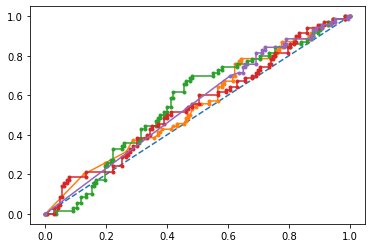

In [ ]:
from matplotlib import pyplot
from sklearn import metrics as metric
ns_probs = [0 for _ in range(len(road_truths))]
ns_fpr, ns_tpr, _ = metric.roc_curve(road_truths, ns_probs)
max_fpr, max_tpr, _ = metric.roc_curve(road_truths, max_scores)
mean_fpr, mean_tpr, _ = metric.roc_curve(road_truths, mean_scores)
median_fpr, median_tpr, _ = metric.roc_curve(road_truths, median_scores)
product_fpr, product_tpr, _ = metric.roc_curve(road_truths,product_scores)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(max_fpr, max_tpr, marker='.', label='Max')
pyplot.plot(mean_fpr, mean_tpr, marker='.', label='Mean')
pyplot.plot(median_fpr, median_tpr, marker='.', label='Median')
pyplot.plot(product_fpr, product_tpr, marker='.', label='Product')

In [ ]:
from sklearn import metrics
print(metrics.roc_auc_score(road_truths, max_scores))
print(metrics.roc_auc_score(road_truths, median_scores))
print(metrics.roc_auc_score(road_truths, mean_scores))
print(metrics.roc_auc_score(road_truths, product_scores))

0.5518481518481518
0.5463536463536464
0.5691308691308692
0.5518981018981018


In [ ]:
from sklearn import metrics

print(metrics.accuracy_score(road_truths, max_preds))
print(metrics.recall_score(road_truths, max_preds))
print(metrics.precision_score(road_truths, max_preds))
print(metrics.f1_score(road_truths, max_preds))
print(metrics.confusion_matrix(road_truths, max_preds))

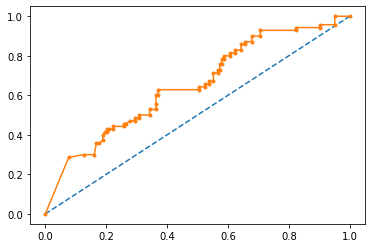

In [ ]:
from matplotlib import pyplot
from sklearn import metrics as metric
ns_probs = [0 for _ in range(len(road_truths))]
ns_fpr, ns_tpr, _ = metric.roc_curve(road_truths, ns_probs)
lr_fpr, lr_tpr, _ = metric.roc_curve(road_truths, max_scores)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

In [ ]:
ROC = pd.DataFrame({'FPR':lr_fpr,
                    'TPR':lr_tpr})

In [ ]:
ROC.to_csv("/content/drive/MyDrive/Owen/final_results/segmented_stacked_cnn_ROC.csv")

# Outputs by layer

In [43]:
class final_layers(nn.Module):
    def __init__(self):
        super(final_layers, self).__init__()
        self.layers = nn.Sigmoid()

    def forward(self, x):
        x = self.layers(x)
        p_none = 1-x
        p_none = torch.prod(p_none, dim=1)
        x = 1-p_none
        return x.squeeze()

In [44]:
class global_average(nn.Module):
    def __init__(self):
        super(global_average, self).__init__()
        self.layers = nn.Sequential(
            Conv2d(512,1, kernel_size=1),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [45]:
# defining the model
model = models.resnet34(pretrained=False)
#set_parameter_requires_grad(model,0)
model.avgpool = global_average()
model.fc = final_layers()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0003)
# defining the loss function
criterion = BCELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Owen/resnet2_output_segmented/epoch38"))

<All keys matched successfully>

In [6]:
class pano_images(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels
        # apply augmentations
        if tfms == 0: # if validating
            self.aug = albumentations.Compose([
                albumentations.Resize(2000, 4000, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
        else: # if training
            self.aug = albumentations.Compose([
                albumentations.Resize(2000, 4000, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
    def __len__(self):
        return (len(self.X))

    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

In [7]:
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
input = pano_images(["/content/drive/MyDrive/Owen/segmented_images_blind_test/29942.jpeg"],[0])[0][0].unsqueeze(dim=0).to(device)

In [9]:
def get_layer(layers, input, feature):
  convolutions = nn.Sequential(*[list(model.children())[i] for i in range(layers)])
  with torch.no_grad():
    output = convolutions(input)
  plt.figure(figsize = (15,15))
  plt.imshow(1/(1+np.exp(-output.cpu().detach()[0][feature])))

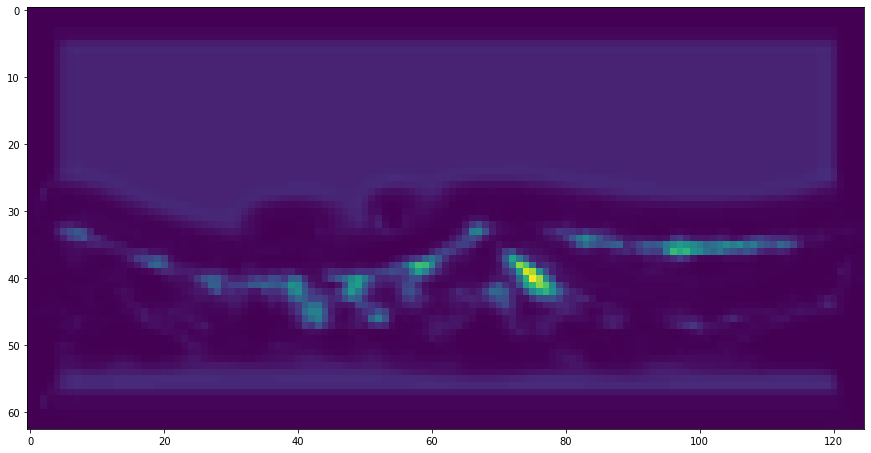

In [30]:
get_layer(9,input,0)

In [46]:
class final_layers2(nn.Module):
    def __init__(self):
        super(final_layers2, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x.squeeze()

In [49]:
# defining the model
model2 = models.resnet34(pretrained=False)
# defining the optimizer
model2.fc = final_layers2()
model2.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
optimizer = Adam(model.parameters(), lr=0.00003)
# defining the loss function
criterion = BCELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model2 = model2.cuda()
    criterion = criterion.cuda()
    
print(model2)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [50]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Owen/maskplusstackedoutput/epoch44"))

<All keys matched successfully>

In [55]:
convolutions = nn.Sequential(*[list(model.children())[i] for i in range(9)])
with torch.no_grad():
  print(model2(convolutions(input)))

tensor(0.0613, device='cuda:0')
